In [2]:
import requests
import json
import sys
import torch
import io
import pandas as pd
from PIL import Image
import open_clip
from tqdm.notebook import tqdm

In [3]:
df = pd.read_parquet('~/data/bild/00000.parquet')
idxs = iter(range(df.shape[0]))

In [129]:
#idx = next(idxs)
#print (idx)
#df.iloc[idx]['Text']

76


'Which AGT Judge Are You? Back 1 2 3 4 5 6 7 8 9 10 * ###img###0### 1 Do you like to dress up stylishly or comfortably? Stylishly Comfortably Both My option is not listed here. ###img###1### 2 Which word best describes you? Loyal Honest Stylish None above ###img###2### 3 Choose a color: Black White Pink Blue ###img###3### 4 What do you like to eat in your evening snacks? French Fries Burger Pasta Donuts ###img###4### 5 Do you like casual wears or formal wears? Casual Wears Formal Wears Both Casual and Formal Wears ###img###5### 6 Which is your favorite AGT Act? Dance performance Singing Magic tricks Gymnastics ###img###6### 7 Which among the phrases do you relate to yourself? I am honest but gentle I am all above love I don\'t get easily shook I like to pull pranks on my friends ###img###7### 8 Which body part you like the most in you? Legs Eyes Nose Hands ###img###8### 9 Who do you like the most in the show? Simon Cowell Howie Mandel Julianne Hough Gabrielle Union ###img###9### 10 How

In [4]:
idx = 76
row = df.iloc[idx]

In [5]:
import re

text = row['Text']
imgs = json.loads(row['Imgs'])

import nltk
from nltk import ngrams 
from nltk.tokenize import word_tokenize

sent_tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle')
ngram_range = (3, 20)
from nltk.corpus import wordnet as wn

In [6]:
def get_filtered_ngrams(before_text, after_text, sent_tokenizer, ngram_range, word_tokenizer):
    candidates = sent_tokenizer.tokenize(before_text) + sent_tokenizer.tokenize(after_text)

    filtered_candidates = []
    for i in range(len(candidates)):
        for n in range(*ngram_range):
            for item in ngrams(candidates[i].split(), n):
                item = " ".join(item)
                word_tokens = word_tokenizer(item)	
                adj_present = False
                verb_or_noun_present = False

                for word in word_tokens:
                    wordtype = set()
                    for tmp in wn.synsets(word):
                        if tmp.name().split('.')[0] == word:
                            wordtype.add(tmp.pos())

                    if ('a' in wordtype or 's' in wordtype):
                        adj_present = True

                    if ('n' in wordtype or 'v' in wordtype):
                        verb_or_noun_present = True

                    if adj_present and verb_or_noun_present:
                        filtered_candidates.append(item)
                        break

    return filtered_candidates


In [7]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
clip_tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')

In [8]:
import time
tc = nltk.classify.textcat.TextCat() 

0it [00:00, ?it/s]

NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!


/home/siddhesh1793/.local/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
NOT ENGLISH, SKIPPING!!!
is your favorite AGT Act? tensor([0.3201])


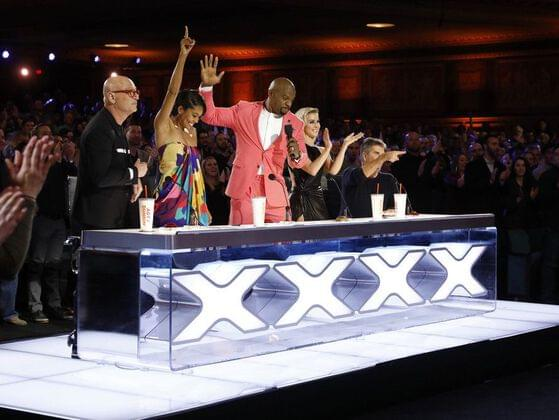

a House to Find out What You Should tensor([0.3007])


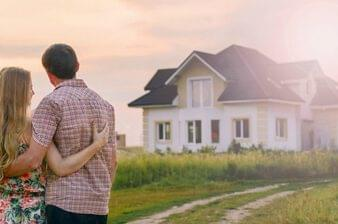

NOT ENGLISH, SKIPPING!!!


In [ ]:
# Loop through all html
for idx, row in tqdm(df.iterrows()):

    # Ignore if # of images is 0
    if row['Page_config']['img_count'] == 0: 
        continue

    text = row['Text']
    
    if tc.guess_language(text) != 'eng':
        print ('NOT ENGLISH, SKIPPING!!!')
        continue

    img_to_url = json.loads(row['Imgs'])

    # Get start and end indices of every image tag in text
    # Hack think more about this
    img_to_idxs = [re.search(img_name, text).span() for img_name in img_to_url.keys() if img_name in text]
    
    last_end = 0
    # For every image 
    for idx, (img_name, img_url) in enumerate(img_to_url.items()):
        # Check if image is jpeg, png
        if ("jpeg" not in img_url) and ("png" not in img_url):
            continue
        
        # Download image and ignore if size is <5KB
        try:
            img_data = requests.get(img_url).content
        except Exception as e:
            continue

        if sys.getsizeof(img_data) * 1e-3 < 5:
            continue

        # get text before and text after image
        start, end = img_to_idxs[idx]
        before_text = text[last_end:start]
        last_end = end

        if idx == (len(img_to_idxs) - 1):
            after_text = text[end:]
        else:
            after_text = text[end:img_to_idxs[idx + 1][0]]

        # Get filtered ngrams for image before and after 
        candidates = get_filtered_ngrams(before_text, after_text, sent_tokenizer, ngram_range, word_tokenize)
        
        if len(candidates) == 0:
            continue

        image = Image.open(io.BytesIO(img_data))
        
        inp_image = preprocess(image).unsqueeze(0)
        tokenized_text = clip_tokenizer(candidates)

        # Read in image
        with torch.no_grad(): #, torch.cuda.amp.autocast():

            image_features = model.encode_image(inp_image)
            text_features = model.encode_text(tokenized_text)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            dot_prod = image_features @ text_features.T
        
            maximum, argmax = dot_prod.max(dim=-1)

            if maximum > 0.3:
                print (candidates[argmax.item()], maximum)
                display(image)
                time.sleep(15)
#                 import pdb; pdb.set_trace()
#                 print ('hello')
